In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd

from fault_tolerant_ml.data import OccupancyData
from fault_tolerant_ml.data import MNist
from fault_tolerant_ml.ml.optimizer import SGDOptimizer

plt.style.use("ggplot")

%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
# data = OccupancyData(filepath="/c/Users/nb304836/Documents/git-repos/large_scale_ml/data/occupancy_data/datatraining.txt")

In [3]:
# data.X.shape

In [4]:
# data.transform()

In [5]:
interval = 100
theta = np.random.randn(5, 3).astype(np.float32)
display(theta)
min_theta_val = theta.min() + 1e-8
max_theta_val = theta.max() + 1e-8
interval = 8
bins = np.linspace(min_theta_val, max_theta_val, interval)
theta_bins = np.digitize(theta, bins).astype(np.int8)

struct_field_names = ["min_val", "max_val", "interval", "bins"]
struct_field_types = [np.float32, np.float32, np.int32, 'b']
struct_field_shapes = [1, 1, 1, (theta.shape)]

data = np.zeros(1, dtype=(list(zip(struct_field_names, struct_field_types, struct_field_shapes))))

data[0] = (min_theta_val, max_theta_val, interval, theta_bins)    

data

array([[ 0.24266258, -0.7364516 ,  0.29375806],
       [ 1.3282232 , -0.9054121 ,  1.2098776 ],
       [-0.6876691 , -0.26824802,  1.6100631 ],
       [-0.5382761 , -1.6756706 ,  2.106024  ],
       [ 0.21044046,  0.1388246 , -1.3098849 ]], dtype=float32)

array([(-1.6756706, 2.106024, 8, [[4, 2, 4], [6, 2, 6], [2, 3, 7], [3, 0, 7], [4, 4, 1]])],
      dtype=[('min_val', '<f4'), ('max_val', '<f4'), ('interval', '<i4'), ('bins', 'i1', (5, 3))])

In [45]:
buf = memoryview(data.tostring())
struct_field_names = ["min_val", "max_val", "interval", "bins"]
struct_field_types = [np.float32, np.float32, np.int32, 'b']
struct_field_shapes = [1, 1, 1, ((5, 3))]
dtype=(list(zip(struct_field_names, struct_field_types, struct_field_shapes)))

data = np.frombuffer(buf, dtype=dtype)
min_theta_val, max_theta_val, interval, theta_bins = data[0]

# Generate lineared space vector
bins = np.linspace(min_theta_val, max_theta_val, interval, dtype=np.float32)
theta = bins[theta_bins].reshape(5, 3)

theta

array([[-0.27242473,  0.8679549 , -0.27242473],
       [ 0.48782834,  0.10770182,  1.2480814 ],
       [ 0.10770182,  1.2480814 , -1.4128044 ],
       [-1.0326778 ,  0.10770182, -0.27242473],
       [ 1.2480814 ,  0.48782834,  0.48782834]], dtype=float32)

In [16]:
t = np.random.randn(784, 10)

In [17]:
u, s, v = np.linalg.svd(t, full_matrices=False)

In [20]:
s.shape

(10,)

## Mnist Logistic regression

In [2]:
data_dir = "/c/Users/nb304836/Documents/git-repos/fault_tolerant_ml/data/"
filepaths = {
    "train": {
        "images": os.path.join(data_dir, "train-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "train-labels-idx1-ubyte.gz")
    },
    "test": {
        "images": os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz")
    }
}

In [3]:
mnist = MNist(filepaths)

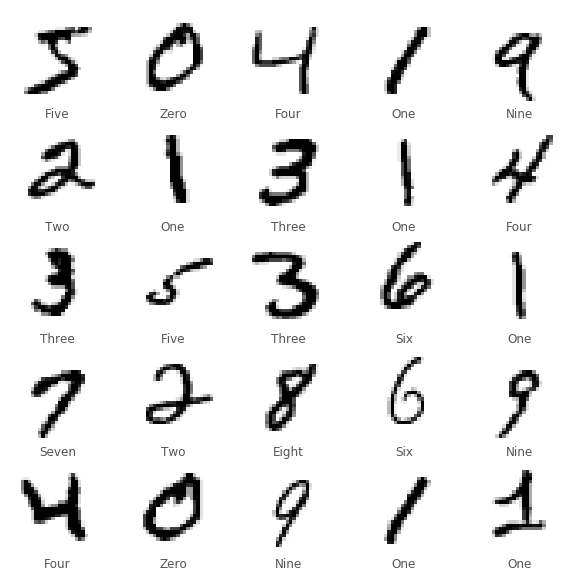

In [4]:
plt.figure(figsize=(10,10))
labels = np.argmax(mnist.y_train, axis=1)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist.X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(mnist.class_names[labels[i]])
plt.show()

In [14]:
from fault_tolerant_ml.ml.loss_fns import cross_entropy_loss, cross_entropy_gradient
from fault_tolerant_ml.ml.linear_model import LogisticRegression
from fault_tolerant_ml.ml.metrics_temp import accuracy_scorev2

In [21]:
def mse(y_pred, y):
    m, _ = y_pred.shape
    e = (y_pred - y)
    return 1.0 / (2.0 * m) * np.sum(e**2)

In [31]:
# optimizer = SGDOptimizer(cross_entropy_loss, cross_entropy_gradient, learning_rate=0.99)
optimizer = SGDOptimizer(cross_entropy_loss, cross_entropy_gradient, learning_rate=0.99)

In [32]:
lr = LogisticRegression(optimizer=optimizer, max_iter=400)

In [33]:
%time lr.fit(mnist.X_train, mnist.y_train)

Iteration=0, delta=0.265, loss=0.686, train acc=0.069
Iteration=100, delta=0.034, loss=0.143, train acc=0.883
Iteration=200, delta=0.029, loss=0.139, train acc=0.891
Iteration=300, delta=0.026, loss=0.137, train acc=0.894
CPU times: user 4min 32s, sys: 1min 28s, total: 6min
Wall time: 1min 6s


In [30]:
labels = lr.predict(mnist.X_test)
accuracy_scorev2(mnist.y_test, labels)

0.9006

In [218]:
lr.theta / np.linalg.norm(lr.theta) * 10

array([[-0.00054303, -0.00793664,  0.01667015, ...,  0.00665261,
         0.00315865,  0.01207278],
       [ 0.00064975,  0.01967466,  0.00646535, ..., -0.01015797,
         0.00753966, -0.00198945],
       [-0.00535639,  0.00502655,  0.00166523, ..., -0.01672691,
        -0.00500027,  0.00400271],
       ...,
       [-0.00019381, -0.02298552, -0.00076836, ..., -0.00537283,
        -0.01550582, -0.01386578],
       [-0.00236113, -0.00917253,  0.00284873, ...,  0.00267229,
        -0.00838161, -0.0020406 ],
       [-0.0102667 ,  0.00211089, -0.01121081, ...,  0.00455561,
         0.00518076, -0.00633913]])

In [216]:
np.linalg.norm(lr.theta)

10.306140735747883

## Autograd

In [10]:
from fault_tolerant_ml.ml.ops.autodiff import Dual
from fault_tolerant_ml.ml.loss_fns import cross_entropy_loss, cross_entropy_gradient
from fault_tolerant_ml.ml.ops import maths_utils
# import math

In [11]:
x = Dual(np.array([5, 2]), 1)
y = Dual(6)

$f = x^{2}y$

In [14]:
f = Dual.pow(x, 2) * y

$\frac{\partial{dy}}{\partial{dx}} = 2xy = [[2 * 5 * 6 = 60], [2 * 2 * 6 = 24]]$

In [15]:
f.derivative

array([60, 24])

In [40]:
h = Dual(np.array([0.1, 0.3, 0.6]), 1)
y = Dual(np.array([0, 1, 1]))

In [41]:
cross_entropy_loss(h._val, y._val)

0.6067196479165844

In [42]:
# cross_entropy_gradient()

In [44]:
f

In [45]:
f = -y * Dual.log(h) - (Dual(1) - y) * Dual.log(Dual(1) - h)

In [49]:
f.mean().derivative

-1.2962962962962965

In [138]:
from autograd import grad
# import autograd.numpy as np

In [405]:
n_samples, n_features = mnist.X_train.shape

In [407]:
_, n_classes = mnist.y_train.shape

In [408]:
weights = np.random.randn(n_features, n_classes)

In [410]:
weights.shape

(784, 10)

In [411]:
def sigmoid(s):
    return 1. / 1. + np.exp(-s)

In [412]:
def loss(weights):
    s = np.dot(X, weights)
    y_pred = sigmoid(s)
    return np.mean(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred))    

In [414]:
s = np.dot(mnist.X_train, weights)
y_pred = sigmoid(s)

In [415]:
l = cross_entropy_loss(y_pred, mnist.y_train)

/c/Users/nb304836/Documents/git-repos/fault_tolerant_ml/fault_tolerant_ml/ml/loss_fns.py:5: RuntimeWarning: divide by zero encountered in log
  return -y * np.log(h) - (1 - y) * np.log(1 - h)
/c/Users/nb304836/Documents/git-repos/fault_tolerant_ml/fault_tolerant_ml/ml/loss_fns.py:5: RuntimeWarning: invalid value encountered in log
  return -y * np.log(h) - (1 - y) * np.log(1 - h)


In [367]:
grad_fn(weights)

array([[-0.41861879],
       [ 0.36414266],
       [-0.22397139]])

In [374]:
losses =[]
for i in range(100):
    l = loss(weights)
    weights -= grad_fn(weights) * 0.01
    losses.append(l)

In [369]:
import matplotlib.pyplot as plt

In [471]:
() + (1, )

(1,)

In [472]:
def decorator_with_arguments(function):
    def wrapper_accepting_arguments(arg1, arg2):
        print("My arguments are: {0}, {1}".format(arg1,arg2))
        function(arg1, arg2)
    return wrapper_accepting_arguments


@decorator_with_arguments
def cities(city_one, city_two):
    print("Cities I love are {0} and {1}".format(city_one, city_two))

cities("Nairobi", "Accra")

My arguments are: Nairobi, Accra
Cities I love are Nairobi and Accra


In [474]:
def ftml_train(function):
    def wrapper():
        print("Running if statement")
        action = True
        if action:
            function()
    return wrapper

In [475]:
@ftml_train
def train_iteration():
    theta = np.random.randn(5, 2)

In [477]:
i = 0
while i < 2:
    train_iteration()
    i += 1

Running if statement
Running if statement


In [482]:
X = np.random.randint(0, 10, size=(3, 3))

In [483]:
X

array([[8, 1, 9],
       [8, 6, 3],
       [9, 4, 5]])

In [487]:
msg = X.tostring()
dtype = X.dtype
shape = str(X.shape)

In [493]:
def concat(data):
    
    x = [b"", b"WORK"]
    x.extend(data)
    return x

In [494]:
x = concat([msg, dtype, shape])
x

[b'',
 b'WORK',
 b'\x08\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\t\x00\x00\x00\x00\x00\x00\x00\x08\x00\x00\x00\x00\x00\x00\x00\x06\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\t\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00',
 dtype('int64'),
 '(3, 3)']

In [495]:
def replacing_decorator_with_args(arg):
    print("defining the decorator")
    def _decorator(function):
        # in this inner function, arg is available too
        print("doing decoration, %r" % arg)
        def _wrapper(*args, **kwargs):
            print("inside wrapper, %r %r" % (args, kwargs))
            return function(*args, **kwargs)
        return _wrapper
    return _decorator

@replacing_decorator_with_args("abc")
def function(*args, **kwargs):
    print("inside function, %r %r" % (args, kwargs))
    return 14

defining the decorator
doing decoration, 'abc'


In [496]:
function(11, 12)

inside wrapper, (11, 12) {}
inside function, (11, 12) {}


14

In [21]:
interval = 100

theta = np.random.randn(784, 10)

min_theta_val = theta.min() + 1e-8
max_theta_val = theta.max() + 1e-8
bins = np.linspace(min_theta_val, max_theta_val, interval)
theta_bins = np.digitize(theta, bins).astype(np.int8)

struct_field_names = ["min_val", "max_val", "interval", "bins"]
struct_field_types = [np.float32, np.float32, np.int32, 'b']
struct_field_shapes = [1, 1, 1, (theta.shape)]

msg = np.zeros(1, dtype=(list(zip(struct_field_names, struct_field_types, struct_field_shapes))))
msg[0] = (min_theta_val, max_theta_val, interval, theta_bins)

In [22]:
msg.nbytes

7852

In [23]:
theta.nbytes

62720

In [24]:
bins

array([-3.41736523, -3.33360606, -3.24984688, -3.16608771, -3.08232854,
       -2.99856936, -2.91481019, -2.83105102, -2.74729184, -2.66353267,
       -2.57977349, -2.49601432, -2.41225515, -2.32849597, -2.2447368 ,
       -2.16097763, -2.07721845, -1.99345928, -1.90970011, -1.82594093,
       -1.74218176, -1.65842258, -1.57466341, -1.49090424, -1.40714506,
       -1.32338589, -1.23962672, -1.15586754, -1.07210837, -0.9883492 ,
       -0.90459002, -0.82083085, -0.73707168, -0.6533125 , -0.56955333,
       -0.48579415, -0.40203498, -0.31827581, -0.23451663, -0.15075746,
       -0.06699829,  0.01676089,  0.10052006,  0.18427923,  0.26803841,
        0.35179758,  0.43555676,  0.51931593,  0.6030751 ,  0.68683428,
        0.77059345,  0.85435262,  0.9381118 ,  1.02187097,  1.10563014,
        1.18938932,  1.27314849,  1.35690766,  1.44066684,  1.52442601,
        1.60818519,  1.69194436,  1.77570353,  1.85946271,  1.94322188,
        2.02698105,  2.11074023,  2.1944994 ,  2.27825857,  2.36

In [23]:
from fault_tolerant_ml.ml.ops.tensor import Tensor

In [24]:
x = Tensor(np.random.randint(0, 100, size=(10, 10)), requires_grad=True)

In [25]:
x.sum().depends_on

[Dependency(tensor=Tensor([[25 60 99 22 68 54 40 21 90  0]
  [40  3 23 75  2 26  4 50 48 46]
  [97 64 77  2 99 80 65 68 67 81]
  [ 5 44 17 51 99 27  7 31  6 99]
  [83 13 65 73 92 13 22 62 75 70]
  [27 27 10 66 42  7 67 12  6 66]
  [65  4 94 36 73  9 33 56 22 20]
  [ 2 62 36 72 23  4 19 43 20 31]
  [52 84 47  0 59 31 98 60 74  4]
  [44 94  2 34 25 54 88 93 79 70]], requires_grad=True), grad_fn=<function Tensor.sum.<locals>.grad_fn at 0x7f230c745f28>)]

In [26]:
x.sum()

Tensor(4596, requires_grad=True)

In [27]:
x.data.sum()

4596

In [5]:
# X = np.random.randn(1000, 10).astype(np.float32)
# y = np.random.randint(0, 2, size=(1000, 5)).astype(np.float32)
X = mnist.X_train.astype(np.float32)
y = mnist.y_train.astype(np.float32)

In [6]:
weights = np.random.randn(784, 10).astype(np.float32) * 0.01
# weights = np.random.randn(10, 5).astype(np.float32)

In [9]:
np.exp(np.dot(X, weights))

array([[1.1211923 , 1.0231351 , 1.0078508 , ..., 0.966235  , 0.8904041 ,
        1.0779842 ],
       [1.1952716 , 1.0903159 , 0.7793827 , ..., 1.0571917 , 1.0319737 ,
        0.8742827 ],
       [1.0754937 , 1.0401366 , 0.90286934, ..., 0.9723414 , 0.9641926 ,
        0.94502026],
       ...,
       [1.1639019 , 1.0075498 , 0.9716273 , ..., 0.9846551 , 0.9944289 ,
        1.0226244 ],
       [1.1476663 , 1.0679898 , 0.87270904, ..., 0.9805132 , 0.9288363 ,
        0.9062653 ],
       [1.1063552 , 1.1387601 , 0.8986623 , ..., 1.1388775 , 1.1276219 ,
        0.8772483 ]], dtype=float32)

In [208]:
s = np.dot(X, weights)

In [209]:
y_pred = 1.0 / (1.0 + np.exp(-s)) 

In [210]:
e = y - y_pred

In [211]:
np.sum(e**2)

146506.12

In [212]:
((1 - y_pred) == 0).sum()

0

In [101]:
np.mean(-y * np.log(y_pred) - (1 - y) * np.log(1 - y_pred))

0.6927005652579574

## Gradient matmul different implementations

In [40]:
%time (1 / X.shape[0] * np.dot(X.T, e))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 140 µs


array([[-0.09729685, -0.13615477, -0.05244835,  0.09696345, -0.20153353],
       [-0.06939318, -0.04232492,  0.14482671,  0.0109492 , -0.12926186],
       [-0.01001322, -0.11077823,  0.12582394,  0.00358664, -0.07273775],
       [ 0.06426514,  0.05376099,  0.01513522,  0.00473866,  0.08187682],
       [-0.12891268, -0.03378609,  0.01343736, -0.07330828, -0.11519925],
       [-0.00456806, -0.07560681,  0.20235442,  0.08535222,  0.00973832],
       [-0.0708738 ,  0.09817479,  0.17513035,  0.19199829,  0.01914438],
       [ 0.30201302, -0.10360824,  0.06912376,  0.20755311, -0.07494355],
       [ 0.07494793,  0.02619907,  0.03669352, -0.00785039, -0.06582595],
       [ 0.05846911, -0.21721211, -0.07979634, -0.06444631,  0.09881642]])

In [41]:
%%time
d_theta = np.zeros_like(weights)

for k in np.arange(y.shape[1]):
    # d_theta[:, k] = 
    d_theta[:, k] = np.mean(X * e[:, np.newaxis, k], axis=0)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 592 µs


In [66]:
d_theta

array([[-0.09729685, -0.13615477, -0.05244835,  0.09696345, -0.20153353],
       [-0.06939318, -0.04232492,  0.14482671,  0.0109492 , -0.12926186],
       [-0.01001322, -0.11077823,  0.12582394,  0.00358664, -0.07273775],
       [ 0.06426514,  0.05376099,  0.01513522,  0.00473866,  0.08187682],
       [-0.12891268, -0.03378609,  0.01343736, -0.07330828, -0.11519925],
       [-0.00456806, -0.07560681,  0.20235442,  0.08535222,  0.00973832],
       [-0.0708738 ,  0.09817479,  0.17513035,  0.19199829,  0.01914438],
       [ 0.30201302, -0.10360824,  0.06912376,  0.20755311, -0.07494355],
       [ 0.07494793,  0.02619907,  0.03669352, -0.00785039, -0.06582595],
       [ 0.05846911, -0.21721211, -0.07979634, -0.06444631,  0.09881642]])

## Fashion MNIST test

In [4]:
!pwd

/Users/sashlinreddy/Documents/repos/fault-tolerant-ml/notebooks


In [14]:
data_dir = "/Users/sashlinreddy/Documents/repos/fault-tolerant-ml/data/fashion-mnist"
filepaths = {
    "train": {
        "images": os.path.join(data_dir, "train-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "train-labels-idx1-ubyte.gz")
    },
    "test": {
        "images": os.path.join(data_dir, "t10k-images-idx3-ubyte.gz"), "labels": os.path.join(data_dir, "t10k-labels-idx1-ubyte.gz")
    }
}

In [15]:
fashion_mnist = MNist(filepaths, fashion=True)

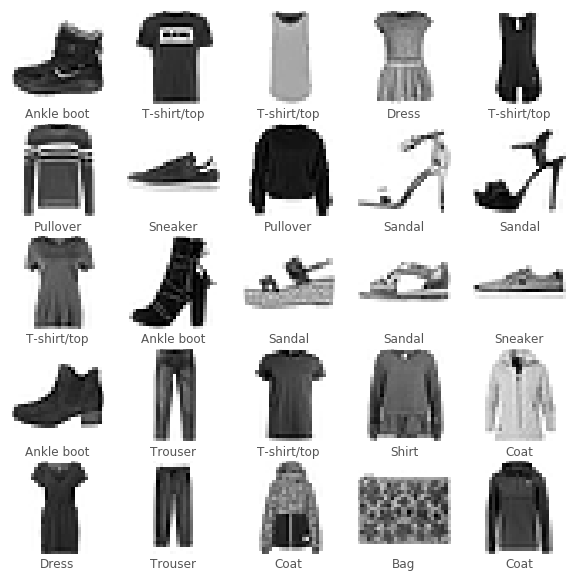

In [16]:
plt.figure(figsize=(10,10))
labels = np.argmax(fashion_mnist.y_train, axis=1)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fashion_mnist.X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(fashion_mnist.class_names[labels[i]])
plt.show()

## Mine log files

In [101]:
logd = "../logs/"
os.path.join(logd, "*/*logfile.*log")

'../logs/*/*logfile.*log'

In [103]:
import glob

files = glob.glob("../logs/*/*logfile.*log")

results = pd.DataFrame(columns=["N_WORKERS", "COMM_PERIOD", "TIME", "ACCURACY"])

for i, filename in enumerate(files):
    with open(filename, "r") as f:
        logfile = f.read()

        enc_run_name_idx = logfile.find("Starting run: ")
        if enc_run_name_idx >= 0:
            enc_run_name_idx += 14
            enc_run_name = re.match("(.*?)\n",logfile[enc_run_name_idx:100]).group()[:-1]
            enc_list = enc_run_name.split("-")
            print(f"Encoded run name: {enc_list}")
            results.loc[i, "N_WORKERS"] = enc_list[0]
            results.loc[i, "COMM_PERIOD"] = enc_list[4]
        time_idx = logfile.find("iterations is") + 14
        # time_sec = logfile[time_idx:time_idx + 9]
        time_sec = re.match("(.*?)s",logfile[time_idx:time_idx + 15]).group()[:-1]
        results.loc[i, "TIME"] = time_sec

        acc_idx = logfile.find("Accuracy=") + 9
        accuracy = logfile[acc_idx:acc_idx + 7]
        results.loc[i, "ACCURACY"] = accuracy

        print(f"time={time_sec}, acc={accuracy}")

time=99.813819, acc=89.0800
Encoded run name: ['7', '1', '1', '0', '1', '0', '0.0', '100']
time=95.492827, acc=90.5400
Encoded run name: ['7', '1', '1', '0', '10', '0', '0.0', '100']
time=72.758503, acc=90.5200
time=75.868868, acc=85.6200


In [100]:
results

,N_WORKERS,COMM_PERIOD,TIME,ACCURACY
0,NaN,NaN,99.813819,89.0800
1,7,1,95.492827,90.5400
2,7,10,72.758503,90.5200
3,NaN,NaN,75.868868,85.6200
